# **Unsupervised Learning**

### Segmentation

https://archive.ics.uci.edu/dataset/157/dodgers+loop+sensor

In [173]:
import time
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import numpy as np
from aeon.utils.windowing import sliding_windows
from aeon.distances import msm_pairwise_distance
from aeon.clustering import TimeSeriesKMeans
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix

In [131]:
data_df = pd.read_csv('dodgers_loop_sensor_dataset/Dodgers.data', header=None)
data_df.rename(columns={0: "date", 1: "car_count"}, inplace=True)
data_df['date'] = pd.to_datetime(data_df['date'], format='%m/%d/%Y %H:%M')
start_date = pd.to_datetime('4/11/2005 7:35', format='%m/%d/%Y %H:%M') # first record with value != -1
end_date = pd.to_datetime('10/1/2005 0:05', format='%m/%d/%Y %H:%M') # 'last' record with value != -1
data_df = data_df[(data_df['date'] >= start_date) & (data_df['date'] <= end_date)]
# Replace -1 values in the 'car_count' column with NaN and interpolate using a linear method
data_df['car_count'] = data_df['car_count'].replace(-1, np.nan)
data_df['car_count'] = data_df['car_count'].interpolate(method='linear')
data_df['car_count'] = data_df['car_count'].astype(int)
data_df['y'] = 0
# *********************************************************************
events_df = pd.read_csv('dodgers_loop_sensor_dataset/Dodgers.events', header=None)
events_df.rename(columns={0: "date", 1: "start_time", 2: "end_time", 3: "attendance", 4: "oppponent", 5: "result"}, inplace=True)
events_df['start_date'] = pd.to_datetime(events_df['date'] + ' ' + events_df['start_time'], format='%m/%d/%y %H:%M:%S')
events_df['end_date'] = pd.to_datetime(events_df['date'] + ' ' + events_df['end_time'], format='%m/%d/%y %H:%M:%S')
events_df['oppponent'] = events_df['oppponent'].astype('category')
events_df['result'] = events_df['result'].astype('category')
events_df.drop(columns=['date', 'start_time', 'end_time'], inplace=True)
events_df = events_df[['start_date', 'end_date'] + [col for col in events_df.columns if col not in ['start_date', 'end_date']]]
# *********************************************************************
for i in range(len(events_df)):
    event_start = events_df['start_date'][i]
    event_end = events_df['end_date'][i]
    data_df.loc[(data_df['date'] >= event_start) & (data_df['date'] <= event_end), 'y'] = 1

In [132]:
data_df.head()

,date,car_count,y
379,2005-04-11 07:35:00,23,0
380,2005-04-11 07:40:00,42,0
381,2005-04-11 07:45:00,37,0
382,2005-04-11 07:50:00,24,0
383,2005-04-11 07:55:00,39,0


In [133]:
events_df.head()

,start_date,end_date,attendance,oppponent,result
0,2005-04-12 13:10:00,2005-04-12 16:23:00,55892,San Francisco,W 9-8
1,2005-04-13 19:10:00,2005-04-13 21:48:00,46514,San Francisco,W 4-1
2,2005-04-15 19:40:00,2005-04-15 21:48:00,51816,San Diego,W 4-0
3,2005-04-16 19:10:00,2005-04-16 21:52:00,54704,San Diego,W 8-3
4,2005-04-17 13:10:00,2005-04-17 15:31:00,53402,San Diego,W 6-0


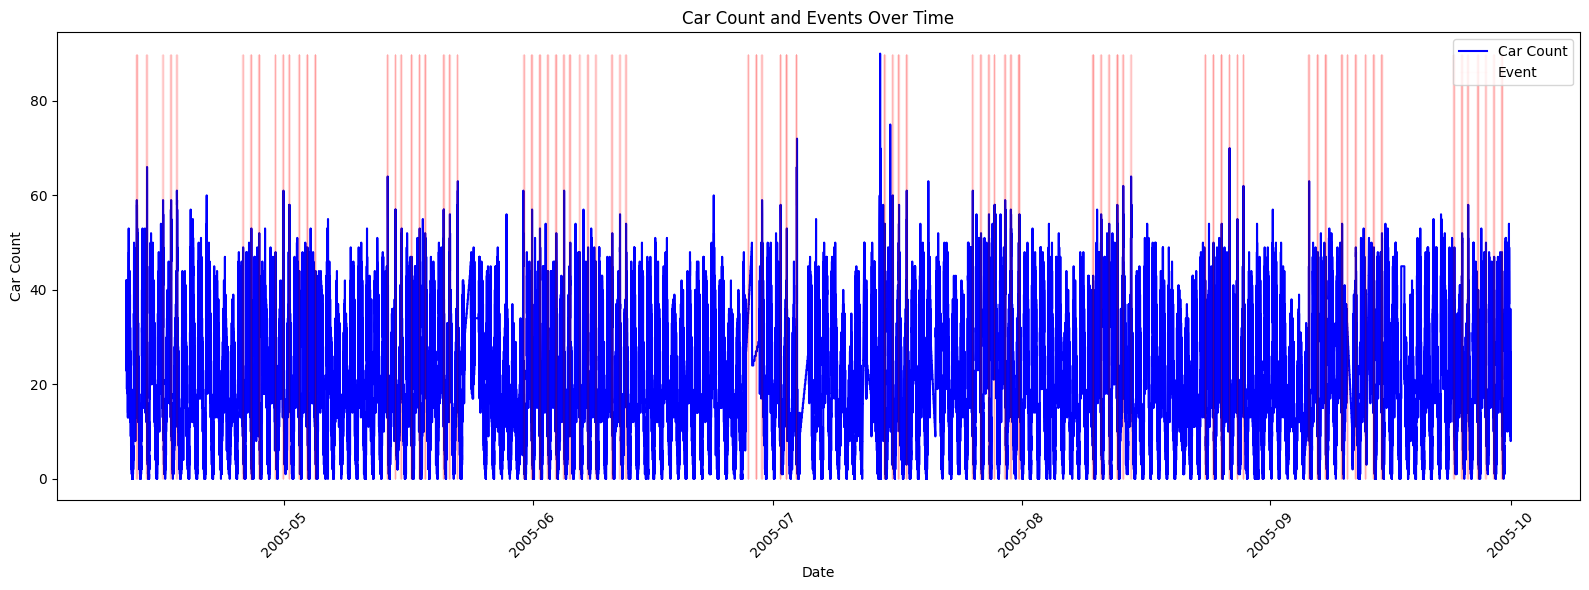

In [134]:
# Compute the overall max of the car_count column
max_val = data_df['car_count'].max()

plt.figure(figsize=(16, 6))
# Plot the original car_count time series
plt.plot(data_df['date'], data_df['car_count'], label="Car Count", color='b')

# For each event (where y equals 1), draw a vertical line from the x-axis (y=0) up to the max value
event_dates = data_df.loc[data_df['y'] == 1, 'date']
plt.vlines(event_dates, ymin=0, ymax=max_val, color='r', alpha=0.01, label="Event", linewidth=1)

plt.xlabel('Date')
plt.ylabel('Car Count')
plt.title('Car Count and Events Over Time')
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

## **Sliding window**

In [144]:
X = data_df['car_count'].to_numpy()

start = time.time()
windows, padding = sliding_windows(X, window_size=12, stride=12)
minutos, segundos = divmod(time.time()-start, 60)
print(f"*******Tiempo de ventanas: {int(minutos)} minutos y {segundos:.2f} segundos*******")

distance_matrix = msm_pairwise_distance(windows)
minutos, segundos = divmod(time.time()-start, 60)
print(f"*******Tiempo Distance Matrix: {int(minutos)} minutos y {segundos:.2f} segundos*******")

*******Tiempo de ventanas: 0 minutos y 0.00 segundos*******
*******Tiempo Distance Matrix: 0 minutos y 10.05 segundos*******


## **TimeSeriesKMeans**

In [137]:
clst = TimeSeriesKMeans(distance="msm", n_clusters=2)
start = time.time()
clst.fit(windows)
minutos, segundos = divmod(time.time()-start, 60)
print(f"*******Tiempo TSKMeans: {int(minutos)} minutos y {segundos:.2f} segundos*******")

*******Tiempo TSKMeans: 1 minutos y 51.81 segundos*******


In [138]:
centroids = clst.cluster_centers_
print("Centroids of the clusters:")
print(centroids)

Centroids of the clusters:
[[[14 11 11 11 10 11 11 11 11 11 11 12]]

 [[32 31 29 29 28 32 23 37 26 27 34 28]]]


## **Predictions**

In [167]:
predictions = clst.predict(windows)
all_preds = np.repeat(predictions, 12).tolist()

In [169]:
predicted_df = data_df.copy()
predicted_df = predicted_df.iloc[:-padding]
predicted_df['prediction'] = all_preds
predicted_df.head()

,date,car_count,y,prediction
379,2005-04-11 07:35:00,23,0,1
380,2005-04-11 07:40:00,42,0,1
381,2005-04-11 07:45:00,37,0,1
382,2005-04-11 07:50:00,24,0,1
383,2005-04-11 07:55:00,39,0,1


## **Metrics**

In [170]:
f1_value = f1_score(predicted_df['y'], predicted_df['prediction'])
print(f"F1 Score: {f1_value:.4f}")
precision_value = precision_score(predicted_df['y'], predicted_df['prediction'])
print(f"Precision: {precision_value:.4f}")
recall_value = recall_score(predicted_df['y'], predicted_df['prediction'])
print(f"Recall: {recall_value:.4f}")
accuracy_value = accuracy_score(predicted_df['y'], predicted_df['prediction'])
print(f"Accuracy: {accuracy_value:.4f}")

F1 Score: 0.1377
Precision: 0.0766
Recall: 0.6808
Accuracy: 0.5196


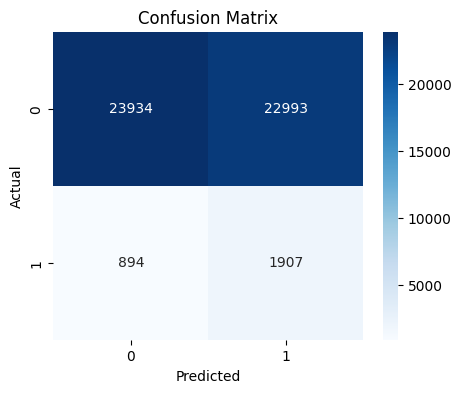

In [171]:
cm = confusion_matrix(predicted_df['y'], predicted_df['prediction'])
plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

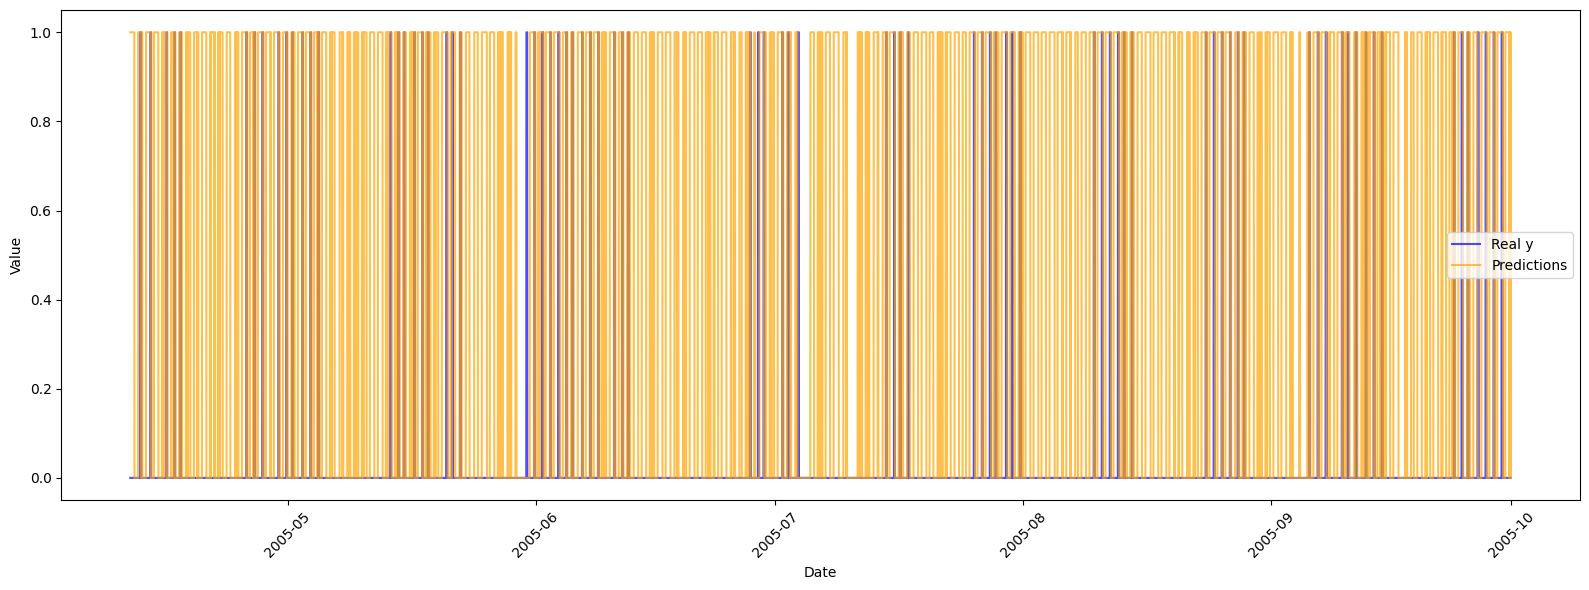

In [172]:
plt.figure(figsize=(16, 6))
plt.plot(predicted_df['date'], predicted_df['y'], label="Real y", color='blue', alpha=0.7)
plt.plot(predicted_df['date'], predicted_df['prediction'], label="Predictions", color='orange', alpha=0.7)
plt.xlabel('Date')
plt.ylabel('Value')
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()